<a href="https://colab.research.google.com/github/mryodo/sun.activity/blob/master/python/vpd/vspace/vpd_vspace_spectr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate
from scipy.optimize import fsolve
from math import *
from scipy.signal import argrelextrema
from imp import reload 

%matplotlib inline
#%matplotlib widget


import seaborn as sns
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

import pandas as pd

from matplotlib.patches import Rectangle

In [0]:
 def SystemSolve(d, dw, beta, dd, eps, init, n=10, N_grid=5000):
    L=n*np.pi
    t=np.linspace(0,L,N_grid)
    h=t[1]-t[0]

    l1=1+dd
    l2=1-dd
    xi=3*beta

    #init=np.array([
    #    2*0.7*np.cos(np.pi/6),
    #    0.1*np.cos(np.pi/6)-0.7*np.sin(np.pi/6)*(-0.05+1),
    #    2*0.5*np.cos(np.pi/3),
    #    -0.05*np.cos(np.pi/3)-0.5*np.sin(np.pi/3)*(-0.1+1)
    #])

    def f(t, x):
        return np.array([
            x[1],
            (1+dd-x[0]*x[0])*x[1]-(1-dw)*x[0]-beta*x[0]*x[0]*x[0]-eps*(x[0]-x[2])-d*(x[1]-x[3]),
            x[3],
            (1-dd-x[2]*x[2])*x[3]-(1+dw)*x[2]-beta*x[2]*x[2]*x[2]-eps*(x[2]-x[0])-d*(x[3]-x[1])
        ])
    
    def rk4(f, h, y0, t0):
        k1 = f(t0, y0)
        k2 = f(t0 + h / 2, y0 + h / 2 * k1)
        k3 = f(t0 + h / 2, y0 + h / 2 * k2)
        k4 = f(t0 + h, y0 + h * k3)
        return y0 + h * (k1 + 2 * k2 + 2 * k3 + k4) / 6


    
    
    vanderpol=np.zeros((4, N_grid))

    t0=0
    y0=init
    for i in range(N_grid):
        tmp = t0 + h
        y = rk4(f, h, y0, t0)
        #if i<120:
        #    print(y)
        t0 = tmp
        vanderpol[:,i] = y0
        y0 = y

    x=vanderpol[0,:]
    dx=vanderpol[1, :]
    y=vanderpol[2,:]
    dy=vanderpol[3,:]
    
    #T=(np.mean(np.diff(t[argrelextrema(y, np.less)]))+np.mean(np.diff(t[argrelextrema(x, np.less)])))/2
    T=1
    W=2*np.pi/T
    p=int(round(T/h))
    
    return t, x, dx, y, dy, T, W, p


In [0]:
 def PseudoRK(d, rPart, init, n=10, N_grid=5000):
    L=n*np.pi
    t=np.linspace(0,L,N_grid)
    h=t[1]-t[0]

    rPart_f=interpolate.interp1d(t, rPart, bounds_error=False, fill_value="extrapolate")

    def f(t, x):
        return np.array([
            x[1],
            -(2*d-1)*x[1]-x[0]+rPart_f(t)
        ])
    
    def rk4(f, h, y0, t0):
        k1 = f(t0, y0)
        k2 = f(t0 + h / 2, y0 + h / 2 * k1)
        k3 = f(t0 + h / 2, y0 + h / 2 * k2)
        k4 = f(t0 + h, y0 + h * k3)
        return y0 + h * (k1 + 2 * k2 + 2 * k3 + k4) / 6


    
    
    ans=np.zeros((2, N_grid))

    t0=0
    y0=init
    for i in range(N_grid):
        tmp = t0 + h
        y = rk4(f, h, y0, t0)
        #if i<120:
        #    print(y)
        t0 = tmp
        ans[:,i] = y0
        y0 = y

    x=ans[0,:]
    dx=ans[1, :]
    
    return t, x, dx


In [0]:
d=15
dw=0.2
beta=0
eps=0
dd=0
N_grid=int(max(d*200, 10000))
n=60

init=np.array([
        2*0.7*np.cos(np.pi/6),
        0.1*np.cos(np.pi/6)-0.7*np.sin(np.pi/6)*(-0.05+1),
        2*0.5*np.cos(np.pi/3),
        -0.05*np.cos(np.pi/3)-0.5*np.sin(np.pi/3)*(-0.1+1)
    ])

t, x, dx, y, dy, T, W, p=SystemSolve(d=d, dw=dw, beta=beta, eps=eps, dd=dd, N_grid=N_grid, n=n, init=init)

u=(x+y)/2
du=(dx+dy)/2
v=(x-y)/2
dv=(dx-dy)/2

rPart=-np.multiply(np.multiply(u, u), dv)-np.multiply(np.multiply(v, v), du)-2*np.multiply(np.multiply(v, u), du)+dw*u


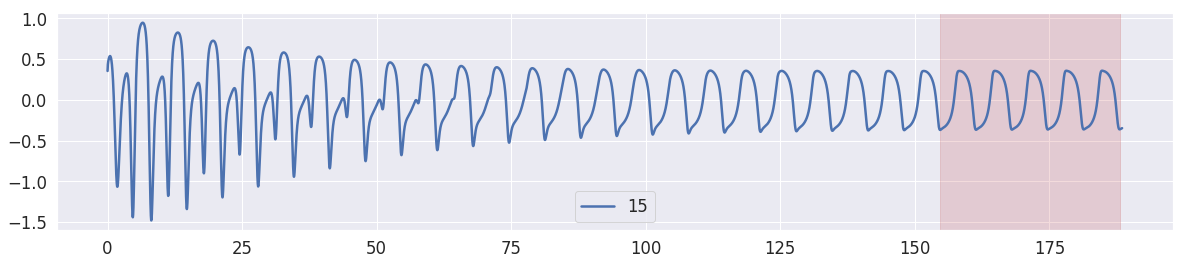

In [20]:
plt.figure(figsize=(20,4))
plt.plot(t, rPart, label=str(d))
plt.axvspan(xmin=t[argrelextrema(rPart, np.less)[0][-6]], xmax=t[argrelextrema(rPart, np.less)[0][-1]], color='r', alpha=0.2)
plt.legend()

In [0]:
p=int(N_grid/(n/2))

fig, ax=plt.subplots(figsize=(20,4))
#plt.magnitude_spectrum(rPart,Fs=2*np.pi/p)
res=ax.magnitude_spectrum(rPart[argrelextrema(rPart, np.less)[0][-6]:argrelextrema(rPart, np.less)[0][-1]], Fs=p)
mag=res[0]
freq=res[1] 
plt.close()

0.8024392676874476


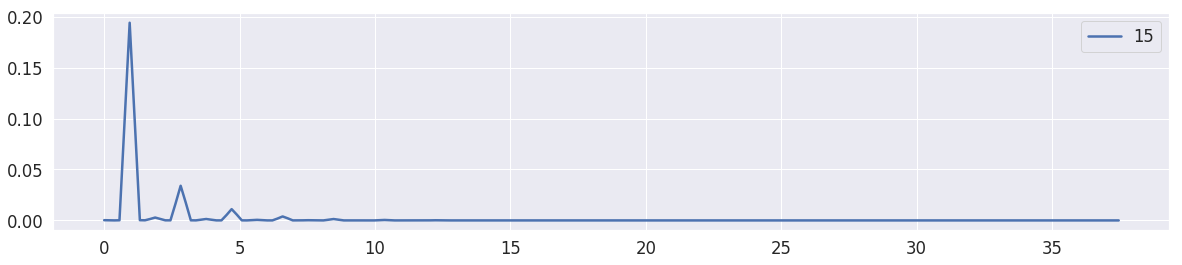

In [25]:
plt.figure(figsize=(20,4))
plt.plot(freq[:200], mag[:200], label=str(d))
plt.legend()
print(np.max(mag)/np.sqrt(np.sum(np.multiply(mag, mag))))

0.8036874783330467


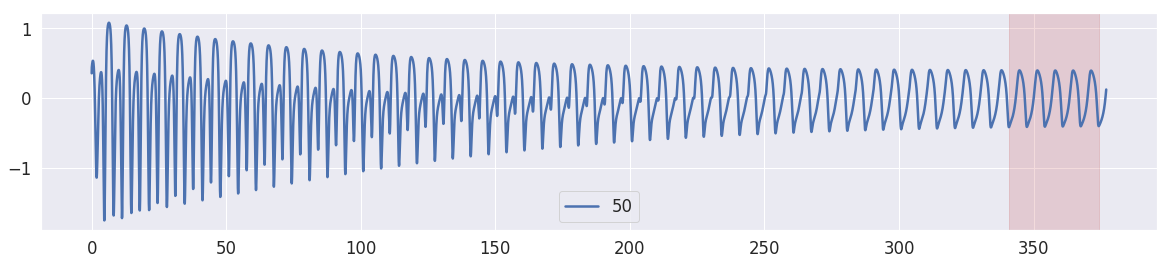

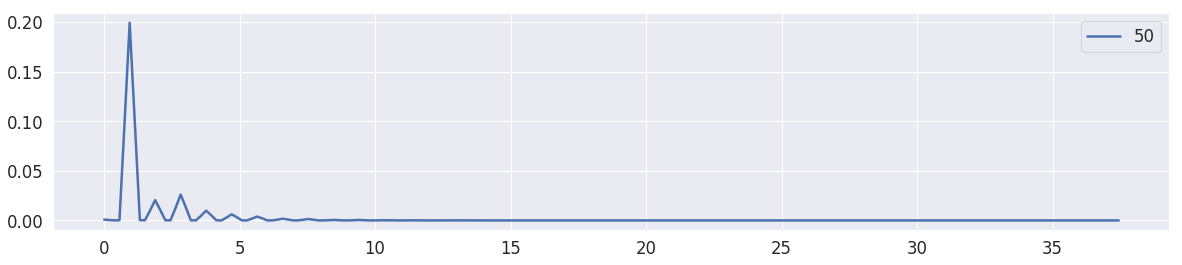

In [28]:
d=50
dw=0.2
beta=0
eps=0
dd=0
N_grid=int(max(d*400, 20000))
n=120

init=np.array([
        2*0.7*np.cos(np.pi/6),
        0.1*np.cos(np.pi/6)-0.7*np.sin(np.pi/6)*(-0.05+1),
        2*0.5*np.cos(np.pi/3),
        -0.05*np.cos(np.pi/3)-0.5*np.sin(np.pi/3)*(-0.1+1)
    ])

t, x, dx, y, dy, T, W, p=SystemSolve(d=d, dw=dw, beta=beta, eps=eps, dd=dd, N_grid=N_grid, n=n, init=init)

u=(x+y)/2
du=(dx+dy)/2
v=(x-y)/2
dv=(dx-dy)/2

rPart=-np.multiply(np.multiply(u, u), dv)-np.multiply(np.multiply(v, v), du)-2*np.multiply(np.multiply(v, u), du)+dw*u


plt.figure(figsize=(20,4))
plt.plot(t, rPart, label=str(d))
argrelextrema(rPart, np.less)
plt.axvspan(xmin=t[argrelextrema(rPart, np.less)[0][-6]], xmax=t[argrelextrema(rPart, np.less)[0][-1]], color='r', alpha=0.2)
plt.legend()

p=int(N_grid/(n/2))

fig, ax=plt.subplots(figsize=(20,4))
#plt.magnitude_spectrum(rPart,Fs=2*np.pi/p)
res=ax.magnitude_spectrum(rPart[argrelextrema(rPart, np.less)[0][-6]:argrelextrema(rPart, np.less)[0][-1]], Fs=p)
mag=res[0]
freq=res[1] 
plt.close()

plt.figure(figsize=(20,4))
plt.plot(freq[:200], mag[:200], label=str(d))
plt.legend()
print(np.max(mag)/np.sqrt(np.sum(np.multiply(mag, mag))))

In [29]:
d_series=np.linspace(1, 50, 100)

peaks=[]

dw=0.2
beta=0
eps=0
dd=0
N_grid=int(max(d*400, 20000))
n=120

init=np.array([
        2*0.7*np.cos(np.pi/6),
        0.1*np.cos(np.pi/6)-0.7*np.sin(np.pi/6)*(-0.05+1),
        2*0.5*np.cos(np.pi/3),
        -0.05*np.cos(np.pi/3)-0.5*np.sin(np.pi/3)*(-0.1+1)
    ])


for d in d_series:


    t, x, dx, y, dy, T, W, p=SystemSolve(d=d, dw=dw, beta=beta, eps=eps, dd=dd, N_grid=N_grid, n=n, init=init)

    u=(x+y)/2
    du=(dx+dy)/2
    v=(x-y)/2
    dv=(dx-dy)/2

    rPart=-np.multiply(np.multiply(u, u), dv)-np.multiply(np.multiply(v, v), du)-2*np.multiply(np.multiply(v, u), du)+dw*u
    p=int(N_grid/(n/2))

    fig, ax=plt.subplots(figsize=(20,4))
    #plt.magnitude_spectrum(rPart,Fs=2*np.pi/p)
    res=ax.magnitude_spectrum(rPart[argrelextrema(rPart, np.less)[0][-6]:argrelextrema(rPart, np.less)[0][-1]], Fs=p)
    mag=res[0]
    freq=res[1] 
    plt.close()

    peaks.append(np.max(mag)/np.sqrt(np.sum(np.multiply(mag, mag))))
    print(d, end=' ')
 

1.0 1.494949494949495 1.98989898989899 2.484848484848485 2.97979797979798 3.474747474747475 3.9696969696969697 4.464646464646465 4.95959595959596 5.454545454545455 5.94949494949495 6.444444444444445 6.9393939393939394 7.434343434343434 7.92929292929293 8.424242424242426 8.91919191919192 9.414141414141415 9.90909090909091 10.404040404040405 10.8989898989899 11.393939393939394 11.88888888888889 12.383838383838384 12.878787878787879 13.373737373737374 13.868686868686869 14.363636363636365 14.85858585858586 15.353535353535355 15.84848484848485 16.343434343434346 16.83838383838384 17.333333333333336 17.82828282828283 18.323232323232325 18.81818181818182 19.313131313131315 19.80808080808081 20.303030303030305 20.7979797979798 21.292929292929294 21.78787878787879 22.282828282828284 22.77777777777778 23.272727272727273 23.767676767676768 24.262626262626263 24.757575757575758 25.252525252525253 25.747474747474747 26.242424242424242 26.737373737373737 27.232323232323232 27.72727272727273 28.2222

No handles with labels found to put in legend.


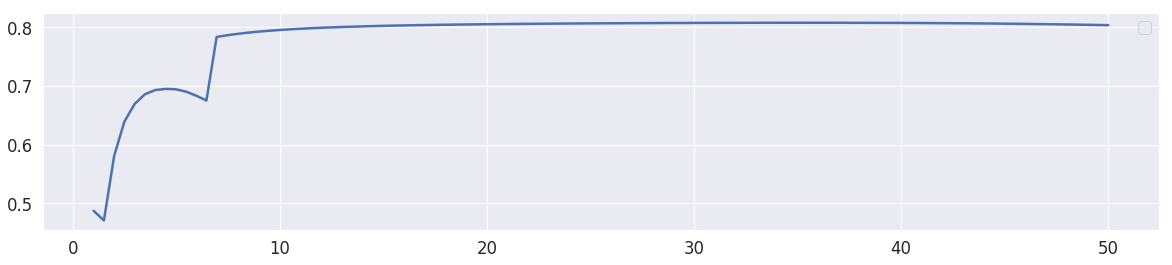

In [30]:
peaks=np.array(peaks)

plt.figure(figsize=(20,4))
plt.plot(d_series, peaks)
plt.legend()

In [31]:
d_series=np.linspace(1, 10, 100)

peaks=[]

dw=0.2
beta=0
eps=0
dd=0
N_grid=int(max(d*400, 20000))
n=120

init=np.array([
        2*0.7*np.cos(np.pi/6),
        0.1*np.cos(np.pi/6)-0.7*np.sin(np.pi/6)*(-0.05+1),
        2*0.5*np.cos(np.pi/3),
        -0.05*np.cos(np.pi/3)-0.5*np.sin(np.pi/3)*(-0.1+1)
    ])


for d in d_series:


    t, x, dx, y, dy, T, W, p=SystemSolve(d=d, dw=dw, beta=beta, eps=eps, dd=dd, N_grid=N_grid, n=n, init=init)

    u=(x+y)/2
    du=(dx+dy)/2
    v=(x-y)/2
    dv=(dx-dy)/2

    rPart=-np.multiply(np.multiply(u, u), dv)-np.multiply(np.multiply(v, v), du)-2*np.multiply(np.multiply(v, u), du)+dw*u
    p=int(N_grid/(n/2))

    fig, ax=plt.subplots(figsize=(20,4))
    #plt.magnitude_spectrum(rPart,Fs=2*np.pi/p)
    res=ax.magnitude_spectrum(rPart[argrelextrema(rPart, np.less)[0][-6]:argrelextrema(rPart, np.less)[0][-1]], Fs=p)
    mag=res[0]
    freq=res[1] 
    plt.close()

    peaks.append(np.max(mag)/np.sqrt(np.sum(np.multiply(mag, mag))))
    print(d, end=' ')
 

1.0 1.0909090909090908 1.1818181818181819 1.2727272727272727 1.3636363636363638 1.4545454545454546 1.5454545454545454 1.6363636363636362 1.7272727272727273 1.8181818181818183 1.9090909090909092 2.0 2.090909090909091 2.1818181818181817 2.2727272727272725 2.3636363636363638 2.4545454545454546 2.5454545454545454 2.6363636363636367 2.7272727272727275 2.8181818181818183 2.909090909090909 3.0 3.090909090909091 3.1818181818181817 3.272727272727273 3.3636363636363638 3.4545454545454546 3.5454545454545454 3.6363636363636362 3.7272727272727275 3.8181818181818183 3.909090909090909 4.0 4.090909090909091 4.181818181818182 4.272727272727273 4.363636363636363 4.454545454545455 4.545454545454545 4.636363636363637 4.7272727272727275 4.818181818181818 4.909090909090909 5.0 5.090909090909091 5.181818181818182 5.2727272727272725 5.363636363636363 5.454545454545455 5.545454545454546 5.636363636363637 5.7272727272727275 5.818181818181818 5.909090909090909 6.0 6.090909090909091 6.181818181818182 6.2727272727

No handles with labels found to put in legend.


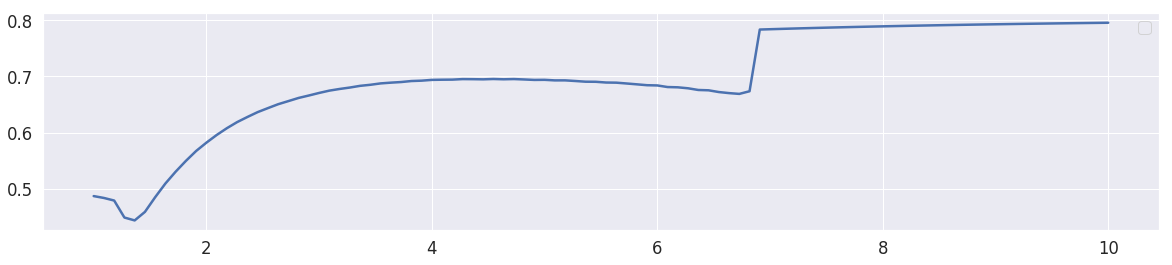

In [32]:
peaks=np.array(peaks)

plt.figure(figsize=(20,4))
plt.plot(d_series, peaks)
plt.legend()

In [33]:
d_series=np.linspace(1, 10, 100)

peaks=[]

dw=0.2
beta=0
eps=0
dd=0
N_grid=int(max(d*800, 40000))
n=240

init=np.array([
        2*0.7*np.cos(np.pi/6),
        0.1*np.cos(np.pi/6)-0.7*np.sin(np.pi/6)*(-0.05+1),
        2*0.5*np.cos(np.pi/3),
        -0.05*np.cos(np.pi/3)-0.5*np.sin(np.pi/3)*(-0.1+1)
    ])


for d in d_series:


    t, x, dx, y, dy, T, W, p=SystemSolve(d=d, dw=dw, beta=beta, eps=eps, dd=dd, N_grid=N_grid, n=n, init=init)

    u=(x+y)/2
    du=(dx+dy)/2
    v=(x-y)/2
    dv=(dx-dy)/2

    rPart=-np.multiply(np.multiply(u, u), dv)-np.multiply(np.multiply(v, v), du)-2*np.multiply(np.multiply(v, u), du)+dw*u
    p=int(N_grid/(n/2))

    fig, ax=plt.subplots(figsize=(20,4))
    #plt.magnitude_spectrum(rPart,Fs=2*np.pi/p)
    res=ax.magnitude_spectrum(rPart[argrelextrema(rPart, np.less)[0][-6]:argrelextrema(rPart, np.less)[0][-1]], Fs=p)
    mag=res[0]
    freq=res[1] 
    plt.close()

    peaks.append(np.max(mag)/np.sqrt(np.sum(np.multiply(mag, mag))))
    print(d, end=' ')
 

1.0 1.0909090909090908 1.1818181818181819 1.2727272727272727 1.3636363636363638 1.4545454545454546 1.5454545454545454 1.6363636363636362 1.7272727272727273 1.8181818181818183 1.9090909090909092 2.0 2.090909090909091 2.1818181818181817 2.2727272727272725 2.3636363636363638 2.4545454545454546 2.5454545454545454 2.6363636363636367 2.7272727272727275 2.8181818181818183 2.909090909090909 3.0 3.090909090909091 3.1818181818181817 3.272727272727273 3.3636363636363638 3.4545454545454546 3.5454545454545454 3.6363636363636362 3.7272727272727275 3.8181818181818183 3.909090909090909 4.0 4.090909090909091 4.181818181818182 4.272727272727273 4.363636363636363 4.454545454545455 4.545454545454545 4.636363636363637 4.7272727272727275 4.818181818181818 4.909090909090909 5.0 5.090909090909091 5.181818181818182 5.2727272727272725 5.363636363636363 5.454545454545455 5.545454545454546 5.636363636363637 5.7272727272727275 5.818181818181818 5.909090909090909 6.0 6.090909090909091 6.181818181818182 6.2727272727

No handles with labels found to put in legend.


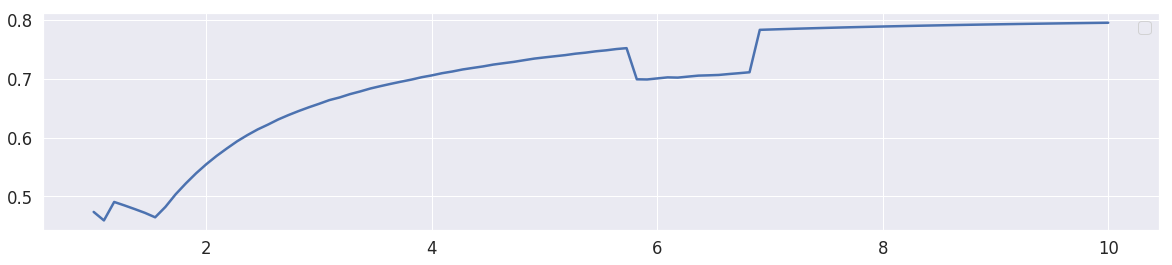

In [34]:
peaks=np.array(peaks)

plt.figure(figsize=(20,4))
plt.plot(d_series, peaks)
plt.legend()

0.7006878796253045


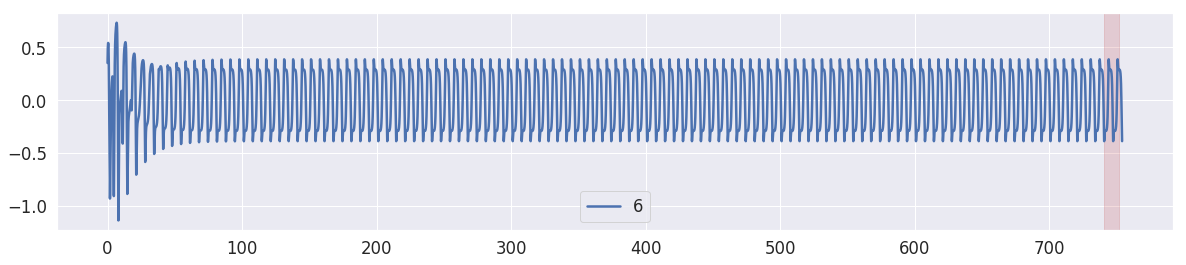

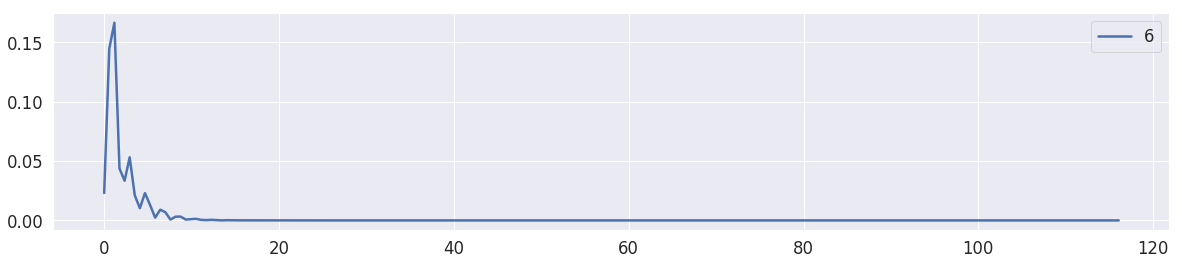

In [36]:
d=6
dw=0.2
beta=0
eps=0
dd=0
N_grid=int(max(d*800, 40000))
n=240

init=np.array([
        2*0.7*np.cos(np.pi/6),
        0.1*np.cos(np.pi/6)-0.7*np.sin(np.pi/6)*(-0.05+1),
        2*0.5*np.cos(np.pi/3),
        -0.05*np.cos(np.pi/3)-0.5*np.sin(np.pi/3)*(-0.1+1)
    ])

t, x, dx, y, dy, T, W, p=SystemSolve(d=d, dw=dw, beta=beta, eps=eps, dd=dd, N_grid=N_grid, n=n, init=init)

u=(x+y)/2
du=(dx+dy)/2
v=(x-y)/2
dv=(dx-dy)/2

rPart=-np.multiply(np.multiply(u, u), dv)-np.multiply(np.multiply(v, v), du)-2*np.multiply(np.multiply(v, u), du)+dw*u


plt.figure(figsize=(20,4))
plt.plot(t, rPart, label=str(d))
argrelextrema(rPart, np.less)
plt.axvspan(xmin=t[argrelextrema(rPart, np.less)[0][-6]], xmax=t[argrelextrema(rPart, np.less)[0][-1]], color='r', alpha=0.2)
plt.legend()

p=int(N_grid/(n/2))

fig, ax=plt.subplots(figsize=(20,4))
#plt.magnitude_spectrum(rPart,Fs=2*np.pi/p)
res=ax.magnitude_spectrum(rPart[argrelextrema(rPart, np.less)[0][-6]:argrelextrema(rPart, np.less)[0][-1]], Fs=p)
mag=res[0]
freq=res[1] 
plt.close()

plt.figure(figsize=(20,4))
plt.plot(freq[:200], mag[:200], label=str(d))
plt.legend()
print(np.max(mag)/np.sqrt(np.sum(np.multiply(mag, mag))))

0.6935732873166036
0.6309073137109942
0.6309073137109942
0.7892507257611825


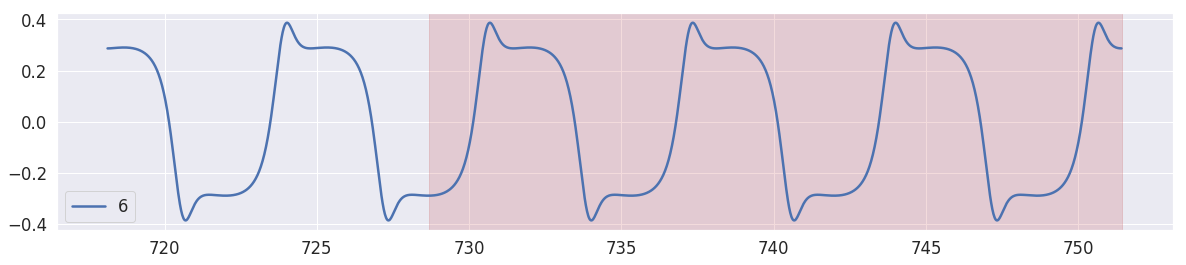

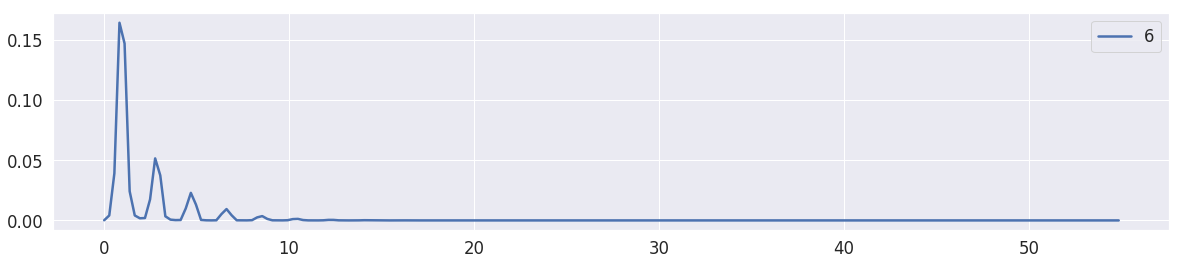

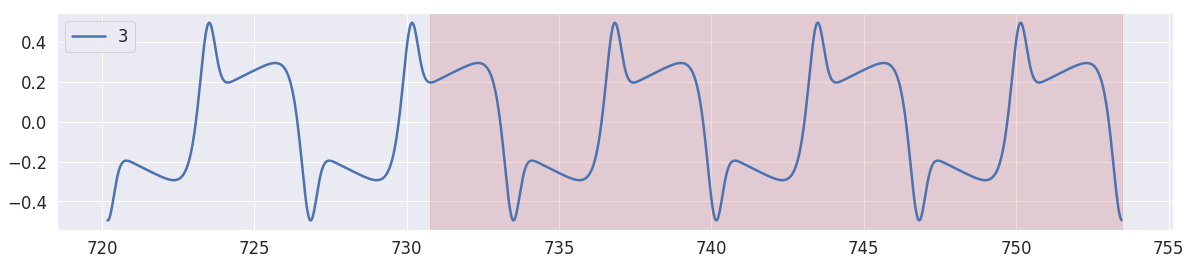

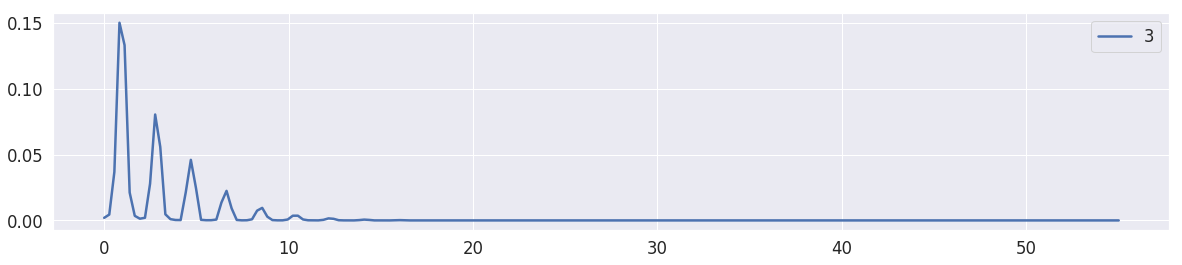

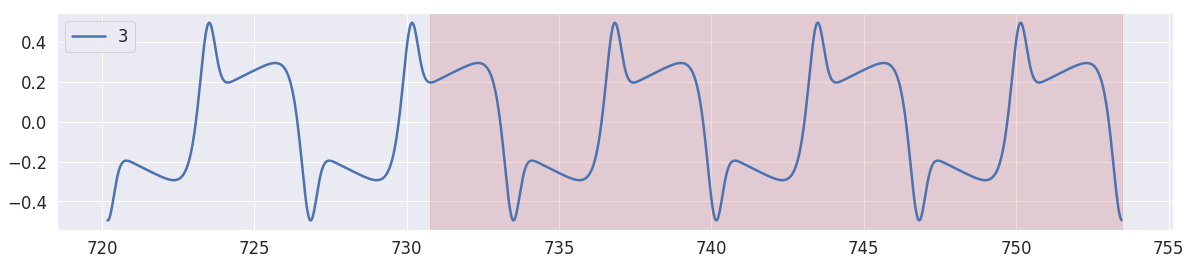

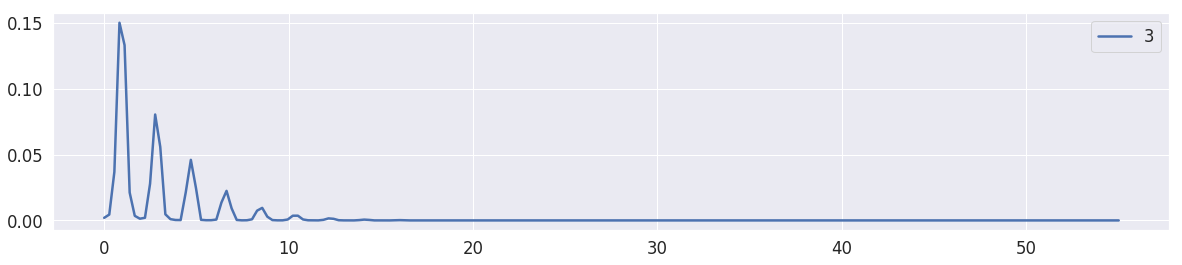

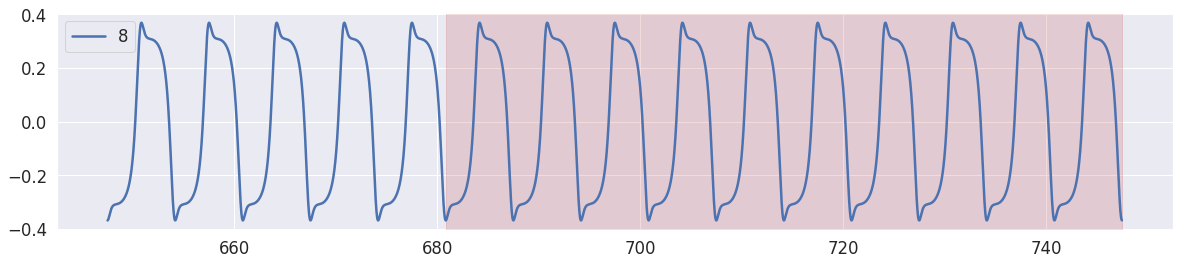

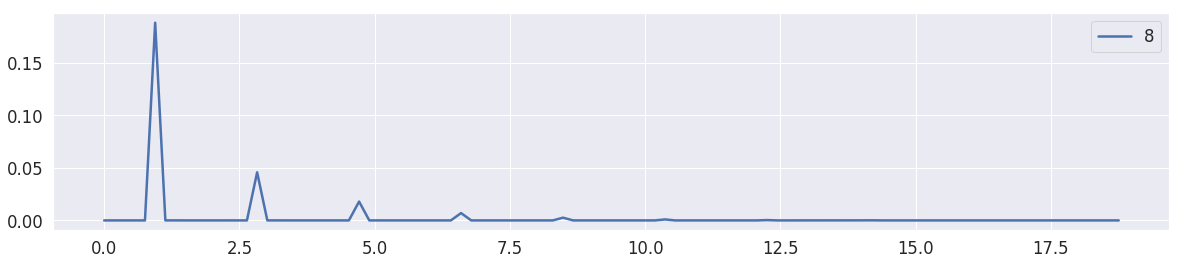

In [43]:
d=6
dw=0.2
beta=0
eps=0
dd=0
N_grid=int(max(d*800, 40000))
n=240

init=np.array([
        2*0.7*np.cos(np.pi/6),
        0.1*np.cos(np.pi/6)-0.7*np.sin(np.pi/6)*(-0.05+1),
        2*0.5*np.cos(np.pi/3),
        -0.05*np.cos(np.pi/3)-0.5*np.sin(np.pi/3)*(-0.1+1)
    ])

t, x, dx, y, dy, T, W, p=SystemSolve(d=d, dw=dw, beta=beta, eps=eps, dd=dd, N_grid=N_grid, n=n, init=init)

u=(x+y)/2
du=(dx+dy)/2
v=(x-y)/2
dv=(dx-dy)/2

rPart=-np.multiply(np.multiply(u, u), dv)-np.multiply(np.multiply(v, v), du)-2*np.multiply(np.multiply(v, u), du)+dw*u


plt.figure(figsize=(20,4))
plt.plot(t[argrelextrema(rPart, np.less)[0][-16]:argrelextrema(rPart, np.less)[0][-1]], rPart[argrelextrema(rPart, np.less)[0][-16]:argrelextrema(rPart, np.less)[0][-1]], label=str(d))
argrelextrema(rPart, np.less)
plt.axvspan(xmin=t[argrelextrema(rPart, np.less)[0][-11]], xmax=t[argrelextrema(rPart, np.less)[0][-1]], color='r', alpha=0.2)
plt.legend()

p=int(N_grid/(n/2))

fig, ax=plt.subplots(figsize=(20,4))
#plt.magnitude_spectrum(rPart,Fs=2*np.pi/p)
res=ax.magnitude_spectrum(rPart[argrelextrema(rPart, np.less)[0][-11]:argrelextrema(rPart, np.less)[0][-1]], Fs=p)
mag=res[0]
freq=res[1] 
plt.close()

plt.figure(figsize=(20,4))
plt.plot(freq[:200], mag[:200], label=str(d))
plt.legend()
print(np.max(mag[1:])/np.sqrt(np.sum(np.multiply(mag[1:], mag[1:]))))

d=3
dw=0.2
beta=0
eps=0
dd=0
N_grid=int(max(d*800, 40000))
n=240

init=np.array([
        2*0.7*np.cos(np.pi/6),
        0.1*np.cos(np.pi/6)-0.7*np.sin(np.pi/6)*(-0.05+1),
        2*0.5*np.cos(np.pi/3),
        -0.05*np.cos(np.pi/3)-0.5*np.sin(np.pi/3)*(-0.1+1)
    ])

t, x, dx, y, dy, T, W, p=SystemSolve(d=d, dw=dw, beta=beta, eps=eps, dd=dd, N_grid=N_grid, n=n, init=init)

u=(x+y)/2
du=(dx+dy)/2
v=(x-y)/2
dv=(dx-dy)/2

rPart=-np.multiply(np.multiply(u, u), dv)-np.multiply(np.multiply(v, v), du)-2*np.multiply(np.multiply(v, u), du)+dw*u


plt.figure(figsize=(20,4))
plt.plot(t[argrelextrema(rPart, np.less)[0][-16]:argrelextrema(rPart, np.less)[0][-1]], rPart[argrelextrema(rPart, np.less)[0][-16]:argrelextrema(rPart, np.less)[0][-1]], label=str(d))
argrelextrema(rPart, np.less)
plt.axvspan(xmin=t[argrelextrema(rPart, np.less)[0][-11]], xmax=t[argrelextrema(rPart, np.less)[0][-1]], color='r', alpha=0.2)
plt.legend()

p=int(N_grid/(n/2))

fig, ax=plt.subplots(figsize=(20,4))
#plt.magnitude_spectrum(rPart,Fs=2*np.pi/p)
res=ax.magnitude_spectrum(rPart[argrelextrema(rPart, np.less)[0][-11]:argrelextrema(rPart, np.less)[0][-1]], Fs=p)
mag=res[0]
freq=res[1] 
plt.close()

plt.figure(figsize=(20,4))
plt.plot(freq[:200], mag[:200], label=str(d))
plt.legend()
print(np.max(mag[1:])/np.sqrt(np.sum(np.multiply(mag[1:], mag[1:]))))

d=3
dw=0.2
beta=0
eps=0
dd=0
N_grid=int(max(d*800, 40000))
n=240

init=np.array([
        2*0.7*np.cos(np.pi/6),
        0.1*np.cos(np.pi/6)-0.7*np.sin(np.pi/6)*(-0.05+1),
        2*0.5*np.cos(np.pi/3),
        -0.05*np.cos(np.pi/3)-0.5*np.sin(np.pi/3)*(-0.1+1)
    ])

t, x, dx, y, dy, T, W, p=SystemSolve(d=d, dw=dw, beta=beta, eps=eps, dd=dd, N_grid=N_grid, n=n, init=init)

u=(x+y)/2
du=(dx+dy)/2
v=(x-y)/2
dv=(dx-dy)/2

rPart=-np.multiply(np.multiply(u, u), dv)-np.multiply(np.multiply(v, v), du)-2*np.multiply(np.multiply(v, u), du)+dw*u


plt.figure(figsize=(20,4))
plt.plot(t[argrelextrema(rPart, np.less)[0][-16]:argrelextrema(rPart, np.less)[0][-1]], rPart[argrelextrema(rPart, np.less)[0][-16]:argrelextrema(rPart, np.less)[0][-1]], label=str(d))
argrelextrema(rPart, np.less)
plt.axvspan(xmin=t[argrelextrema(rPart, np.less)[0][-11]], xmax=t[argrelextrema(rPart, np.less)[0][-1]], color='r', alpha=0.2)
plt.legend()

p=int(N_grid/(n/2))

fig, ax=plt.subplots(figsize=(20,4))
#plt.magnitude_spectrum(rPart,Fs=2*np.pi/p)
res=ax.magnitude_spectrum(rPart[argrelextrema(rPart, np.less)[0][-11]:argrelextrema(rPart, np.less)[0][-1]], Fs=p)
mag=res[0]
freq=res[1] 
plt.close()

plt.figure(figsize=(20,4))
plt.plot(freq[:200], mag[:200], label=str(d))
plt.legend()
print(np.max(mag[1:])/np.sqrt(np.sum(np.multiply(mag[1:], mag[1:]))))

d=8
dw=0.2
beta=0
eps=0
dd=0
N_grid=int(max(d*800, 40000))
n=240

init=np.array([
        2*0.7*np.cos(np.pi/6),
        0.1*np.cos(np.pi/6)-0.7*np.sin(np.pi/6)*(-0.05+1),
        2*0.5*np.cos(np.pi/3),
        -0.05*np.cos(np.pi/3)-0.5*np.sin(np.pi/3)*(-0.1+1)
    ])

t, x, dx, y, dy, T, W, p=SystemSolve(d=d, dw=dw, beta=beta, eps=eps, dd=dd, N_grid=N_grid, n=n, init=init)

u=(x+y)/2
du=(dx+dy)/2
v=(x-y)/2
dv=(dx-dy)/2

rPart=-np.multiply(np.multiply(u, u), dv)-np.multiply(np.multiply(v, v), du)-2*np.multiply(np.multiply(v, u), du)+dw*u


plt.figure(figsize=(20,4))
plt.plot(t[argrelextrema(rPart, np.less)[0][-16]:argrelextrema(rPart, np.less)[0][-1]], rPart[argrelextrema(rPart, np.less)[0][-16]:argrelextrema(rPart, np.less)[0][-1]], label=str(d))
argrelextrema(rPart, np.less)
plt.axvspan(xmin=t[argrelextrema(rPart, np.less)[0][-11]], xmax=t[argrelextrema(rPart, np.less)[0][-1]], color='r', alpha=0.2)
plt.legend()

p=int(N_grid/(n/2))

fig, ax=plt.subplots(figsize=(20,4))
#plt.magnitude_spectrum(rPart,Fs=2*np.pi/p)
res=ax.magnitude_spectrum(rPart[argrelextrema(rPart, np.less)[0][-11]:argrelextrema(rPart, np.less)[0][-1]], Fs=p)
mag=res[0]
freq=res[1] 
plt.close()

plt.figure(figsize=(20,4))
plt.plot(freq[:200], mag[:200], label=str(d))
plt.legend()
print(np.max(mag[1:])/np.sqrt(np.sum(np.multiply(mag[1:], mag[1:]))))

0.6628883167191598


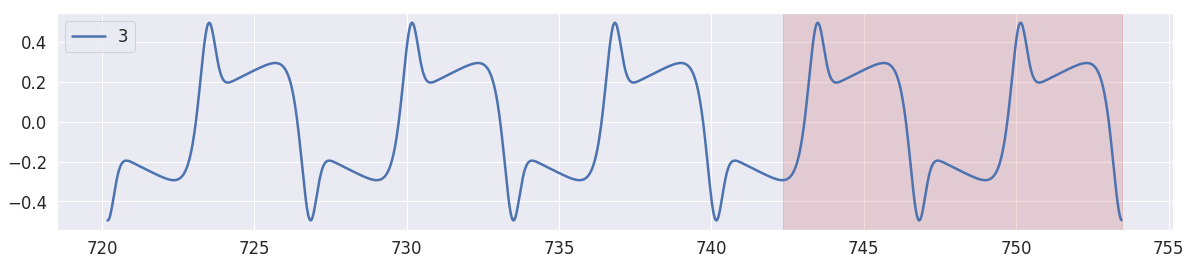

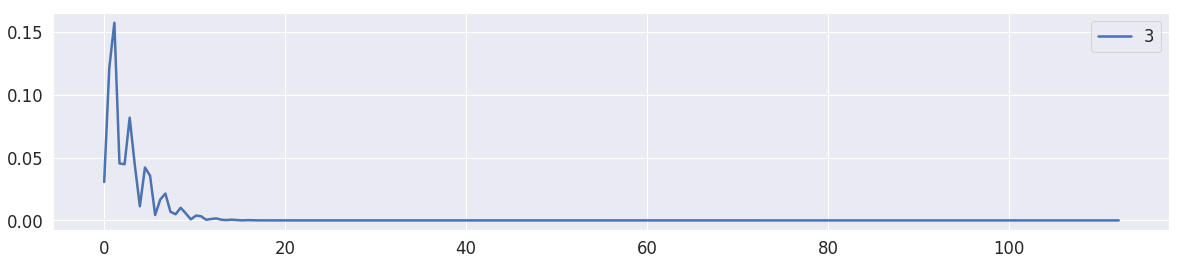

In [44]:
d=3
dw=0.2
beta=0
eps=0
dd=0
N_grid=int(max(d*800, 40000))
n=240

init=np.array([
        2*0.7*np.cos(np.pi/6),
        0.1*np.cos(np.pi/6)-0.7*np.sin(np.pi/6)*(-0.05+1),
        2*0.5*np.cos(np.pi/3),
        -0.05*np.cos(np.pi/3)-0.5*np.sin(np.pi/3)*(-0.1+1)
    ])

t, x, dx, y, dy, T, W, p=SystemSolve(d=d, dw=dw, beta=beta, eps=eps, dd=dd, N_grid=N_grid, n=n, init=init)

u=(x+y)/2
du=(dx+dy)/2
v=(x-y)/2
dv=(dx-dy)/2

rPart=-np.multiply(np.multiply(u, u), dv)-np.multiply(np.multiply(v, v), du)-2*np.multiply(np.multiply(v, u), du)+dw*u


plt.figure(figsize=(20,4))
plt.plot(t[argrelextrema(rPart, np.less)[0][-16]:argrelextrema(rPart, np.less)[0][-1]], rPart[argrelextrema(rPart, np.less)[0][-16]:argrelextrema(rPart, np.less)[0][-1]], label=str(d))
argrelextrema(rPart, np.less)
plt.axvspan(xmin=t[argrelextrema(rPart, np.less)[0][-6]], xmax=t[argrelextrema(rPart, np.less)[0][-1]], color='r', alpha=0.2)
plt.legend()

p=int(N_grid/(n/2))

fig, ax=plt.subplots(figsize=(20,4))
#plt.magnitude_spectrum(rPart,Fs=2*np.pi/p)
res=ax.magnitude_spectrum(rPart[argrelextrema(rPart, np.less)[0][-6]:argrelextrema(rPart, np.less)[0][-1]], Fs=p)
mag=res[0]
freq=res[1] 
plt.close()

plt.figure(figsize=(20,4))
plt.plot(freq[:200], mag[:200], label=str(d))
plt.legend()
print(np.max(mag[1:])/np.sqrt(np.sum(np.multiply(mag[1:], mag[1:]))))

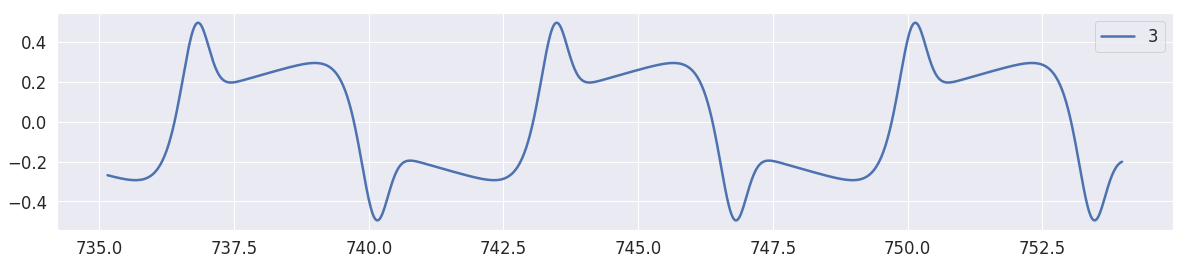

In [46]:
plt.figure(figsize=(20,4))
plt.plot(t[-1000:], rPart[-1000:], label=str(d))
plt.legend()

In [50]:
target=np.min(rPart[-1000:])
eps=0.01

t[argrelextrema(rPart, np.less)[0][np.abs(rPart[argrelextrema(rPart, np.less)]-target)<eps]]

array([ 34.60864989,  41.28155951,  47.9356191 ,  54.58967869,
        61.24373828,  67.89779787,  74.55185747,  81.20591706,
        87.85997665,  94.51403624, 101.16809583, 107.84100545,
       114.49506504, 121.14912464, 127.80318423, 134.45724382,
       141.11130341, 147.765363  , 154.41942259, 161.07348219,
       167.74639181, 174.4004514 , 181.05451099, 187.70857058,
       194.36263017, 201.01668976, 207.67074936, 214.32480895,
       220.97886854, 227.65177816, 234.30583775, 240.95989734,
       247.61395693, 254.26801653, 260.92207612, 267.57613571,
       274.2301953 , 280.88425489, 287.53831449, 294.2112241 ,
       300.8652837 , 307.51934329, 314.17340288, 320.82746247,
       327.48152206, 334.13558165, 340.78964125, 347.44370084,
       354.11661046, 360.77067005, 367.42472964, 374.07878923,
       380.73284882, 387.38690842, 394.04096801, 400.6950276 ,
       407.34908719, 414.00314678, 420.6760564 , 427.33011599,
       433.98417559, 440.63823518, 447.29229477, 453.94

0.7764840293856797


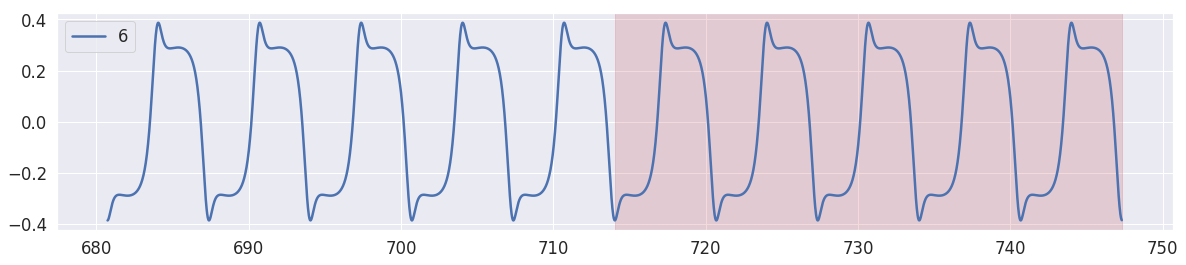

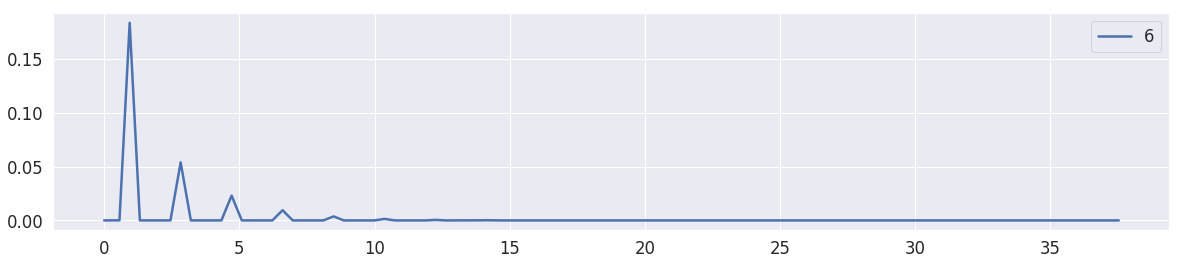

In [52]:
d=6
dw=0.2
beta=0
eps=0
dd=0
N_grid=int(max(d*800, 40000))
n=240

init=np.array([
        2*0.7*np.cos(np.pi/6),
        0.1*np.cos(np.pi/6)-0.7*np.sin(np.pi/6)*(-0.05+1),
        2*0.5*np.cos(np.pi/3),
        -0.05*np.cos(np.pi/3)-0.5*np.sin(np.pi/3)*(-0.1+1)
    ])

t, x, dx, y, dy, T, W, p=SystemSolve(d=d, dw=dw, beta=beta, eps=eps, dd=dd, N_grid=N_grid, n=n, init=init)

u=(x+y)/2
du=(dx+dy)/2
v=(x-y)/2
dv=(dx-dy)/2

rPart=-np.multiply(np.multiply(u, u), dv)-np.multiply(np.multiply(v, v), du)-2*np.multiply(np.multiply(v, u), du)+dw*u
target=np.min(rPart[-1000:])
eps=0.01
ind=argrelextrema(rPart, np.less)[0][np.abs(rPart[argrelextrema(rPart, np.less)]-target)<eps]

plt.figure(figsize=(20,4))
plt.plot(t[ind[-11]:ind[-1]], rPart[ind[-11]:ind[-1]], label=str(d))
argrelextrema(rPart, np.less)
plt.axvspan(xmin=t[ind[-6]], xmax=t[ind[-1]], color='r', alpha=0.2)
plt.legend()

p=int(N_grid/(n/2))

fig, ax=plt.subplots(figsize=(20,4))
#plt.magnitude_spectrum(rPart,Fs=2*np.pi/p)
res=ax.magnitude_spectrum(rPart[ind[-6]:ind[-1]], Fs=p)
mag=res[0]
freq=res[1] 
plt.close()

plt.figure(figsize=(20,4))
plt.plot(freq[:200], mag[:200], label=str(d))
plt.legend()
print(np.max(mag[1:])/np.sqrt(np.sum(np.multiply(mag[1:], mag[1:]))))

In [53]:
d_series=np.linspace(1, 50, 100)

peaks=[]

dw=0.2
beta=0
eps=0
dd=0
N_grid=int(max(d*400, 20000))
n=120

init=np.array([
        2*0.7*np.cos(np.pi/6),
        0.1*np.cos(np.pi/6)-0.7*np.sin(np.pi/6)*(-0.05+1),
        2*0.5*np.cos(np.pi/3),
        -0.05*np.cos(np.pi/3)-0.5*np.sin(np.pi/3)*(-0.1+1)
    ])


for d in d_series:


    t, x, dx, y, dy, T, W, p=SystemSolve(d=d, dw=dw, beta=beta, eps=eps, dd=dd, N_grid=N_grid, n=n, init=init)

    u=(x+y)/2
    du=(dx+dy)/2
    v=(x-y)/2
    dv=(dx-dy)/2

    rPart=-np.multiply(np.multiply(u, u), dv)-np.multiply(np.multiply(v, v), du)-2*np.multiply(np.multiply(v, u), du)+dw*u
    target=np.min(rPart[-1000:])
    eps=0.01
    ind=argrelextrema(rPart, np.less)[0][np.abs(rPart[argrelextrema(rPart, np.less)]-target)<eps]
    p=int(N_grid/(n/2))

    fig, ax=plt.subplots(figsize=(20,4))
    #plt.magnitude_spectrum(rPart,Fs=2*np.pi/p)
    res=ax.magnitude_spectrum(rPart[ind[-6]:ind[-1]], Fs=p)
    mag=res[0]
    freq=res[1] 
    plt.close()

    peaks.append(np.max(mag)/np.sqrt(np.sum(np.multiply(mag, mag))))
    print(d, end=' ')
 

1.0 1.494949494949495 1.98989898989899 2.484848484848485 2.97979797979798 3.474747474747475 3.9696969696969697 4.464646464646465 4.95959595959596 5.454545454545455 5.94949494949495 6.444444444444445 6.9393939393939394 7.434343434343434 7.92929292929293 8.424242424242426 8.91919191919192 9.414141414141415 9.90909090909091 10.404040404040405 10.8989898989899 11.393939393939394 11.88888888888889 12.383838383838384 12.878787878787879 13.373737373737374 13.868686868686869 14.363636363636365 14.85858585858586 15.353535353535355 15.84848484848485 16.343434343434346 16.83838383838384 17.333333333333336 17.82828282828283 18.323232323232325 18.81818181818182 19.313131313131315 19.80808080808081 20.303030303030305 20.7979797979798 21.292929292929294 21.78787878787879 22.282828282828284 22.77777777777778 23.272727272727273 23.767676767676768 24.262626262626263 24.757575757575758 25.252525252525253 25.747474747474747 26.242424242424242 26.737373737373737 27.232323232323232 27.72727272727273 28.2222

No handles with labels found to put in legend.


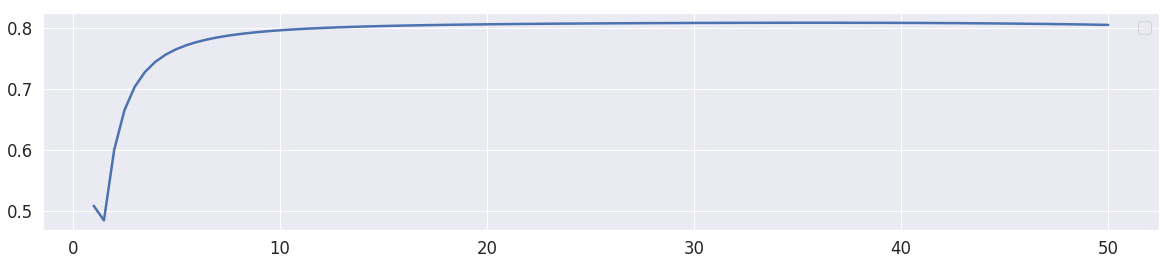

In [54]:
peaks=np.array(peaks)

plt.figure(figsize=(20,4))
plt.plot(d_series, peaks)
plt.legend()

In [55]:
d_series=np.linspace(1, 10, 100)

peaks=[]

dw=0.2
beta=0
eps=0
dd=0
N_grid=int(max(d*400, 20000))
n=120

init=np.array([
        2*0.7*np.cos(np.pi/6),
        0.1*np.cos(np.pi/6)-0.7*np.sin(np.pi/6)*(-0.05+1),
        2*0.5*np.cos(np.pi/3),
        -0.05*np.cos(np.pi/3)-0.5*np.sin(np.pi/3)*(-0.1+1)
    ])


for d in d_series:


    t, x, dx, y, dy, T, W, p=SystemSolve(d=d, dw=dw, beta=beta, eps=eps, dd=dd, N_grid=N_grid, n=n, init=init)

    u=(x+y)/2
    du=(dx+dy)/2
    v=(x-y)/2
    dv=(dx-dy)/2

    rPart=-np.multiply(np.multiply(u, u), dv)-np.multiply(np.multiply(v, v), du)-2*np.multiply(np.multiply(v, u), du)+dw*u
    target=np.min(rPart[-1000:])
    eps=0.01
    ind=argrelextrema(rPart, np.less)[0][np.abs(rPart[argrelextrema(rPart, np.less)]-target)<eps]
    p=int(N_grid/(n/2))

    fig, ax=plt.subplots(figsize=(20,4))
    #plt.magnitude_spectrum(rPart,Fs=2*np.pi/p)
    res=ax.magnitude_spectrum(rPart[ind[-6]:ind[-1]], Fs=p)
    mag=res[0]
    freq=res[1] 
    plt.close()

    peaks.append(np.max(mag)/np.sqrt(np.sum(np.multiply(mag, mag))))
    print(d, end=' ')
 

1.0 1.0909090909090908 1.1818181818181819 1.2727272727272727 1.3636363636363638 1.4545454545454546 1.5454545454545454 1.6363636363636362 1.7272727272727273 1.8181818181818183 1.9090909090909092 2.0 2.090909090909091 2.1818181818181817 2.2727272727272725 2.3636363636363638 2.4545454545454546 2.5454545454545454 2.6363636363636367 2.7272727272727275 2.8181818181818183 2.909090909090909 3.0 3.090909090909091 3.1818181818181817 3.272727272727273 3.3636363636363638 3.4545454545454546 3.5454545454545454 3.6363636363636362 3.7272727272727275 3.8181818181818183 3.909090909090909 4.0 4.090909090909091 4.181818181818182 4.272727272727273 4.363636363636363 4.454545454545455 4.545454545454545 4.636363636363637 4.7272727272727275 4.818181818181818 4.909090909090909 5.0 5.090909090909091 5.181818181818182 5.2727272727272725 5.363636363636363 5.454545454545455 5.545454545454546 5.636363636363637 5.7272727272727275 5.818181818181818 5.909090909090909 6.0 6.090909090909091 6.181818181818182 6.2727272727

No handles with labels found to put in legend.


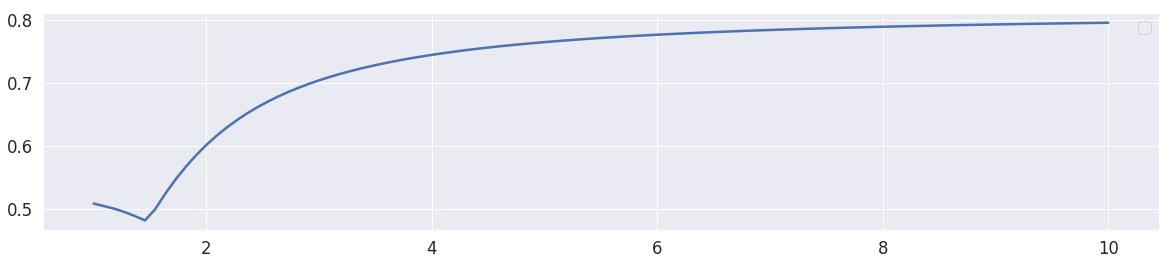

In [56]:
peaks=np.array(peaks)

plt.figure(figsize=(20,4))
plt.plot(d_series, peaks)
plt.legend()

In [57]:
d_series=np.linspace(1, 50, 100)

peaks=[]

dw=0.2
beta=0
eps=0
dd=0
N_grid=int(max(d*800, 40000))
n=240

init=np.array([
        2*0.7*np.cos(np.pi/6),
        0.1*np.cos(np.pi/6)-0.7*np.sin(np.pi/6)*(-0.05+1),
        2*0.5*np.cos(np.pi/3),
        -0.05*np.cos(np.pi/3)-0.5*np.sin(np.pi/3)*(-0.1+1)
    ])


for d in d_series:


    t, x, dx, y, dy, T, W, p=SystemSolve(d=d, dw=dw, beta=beta, eps=eps, dd=dd, N_grid=N_grid, n=n, init=init)

    u=(x+y)/2
    du=(dx+dy)/2
    v=(x-y)/2
    dv=(dx-dy)/2

    rPart=-np.multiply(np.multiply(u, u), dv)-np.multiply(np.multiply(v, v), du)-2*np.multiply(np.multiply(v, u), du)+dw*u
    target=np.min(rPart[-1000:])
    eps=0.01
    ind=argrelextrema(rPart, np.less)[0][np.abs(rPart[argrelextrema(rPart, np.less)]-target)<eps]
    p=int(N_grid/(n/2))

    fig, ax=plt.subplots(figsize=(20,4))
    #plt.magnitude_spectrum(rPart,Fs=2*np.pi/p)
    res=ax.magnitude_spectrum(rPart[ind[-6]:ind[-1]], Fs=p)
    mag=res[0]
    freq=res[1] 
    plt.close()

    peaks.append(np.max(mag)/np.sqrt(np.sum(np.multiply(mag, mag))))
    print(d, end=' ')
 

1.0 1.494949494949495 1.98989898989899 2.484848484848485 2.97979797979798 3.474747474747475 3.9696969696969697 4.464646464646465 4.95959595959596 5.454545454545455 5.94949494949495 6.444444444444445 6.9393939393939394 7.434343434343434 7.92929292929293 8.424242424242426 8.91919191919192 9.414141414141415 9.90909090909091 10.404040404040405 10.8989898989899 11.393939393939394 11.88888888888889 12.383838383838384 12.878787878787879 13.373737373737374 13.868686868686869 14.363636363636365 14.85858585858586 15.353535353535355 15.84848484848485 16.343434343434346 16.83838383838384 17.333333333333336 17.82828282828283 18.323232323232325 18.81818181818182 19.313131313131315 19.80808080808081 20.303030303030305 20.7979797979798 21.292929292929294 21.78787878787879 22.282828282828284 22.77777777777778 23.272727272727273 23.767676767676768 24.262626262626263 24.757575757575758 25.252525252525253 25.747474747474747 26.242424242424242 26.737373737373737 27.232323232323232 27.72727272727273 28.2222

No handles with labels found to put in legend.


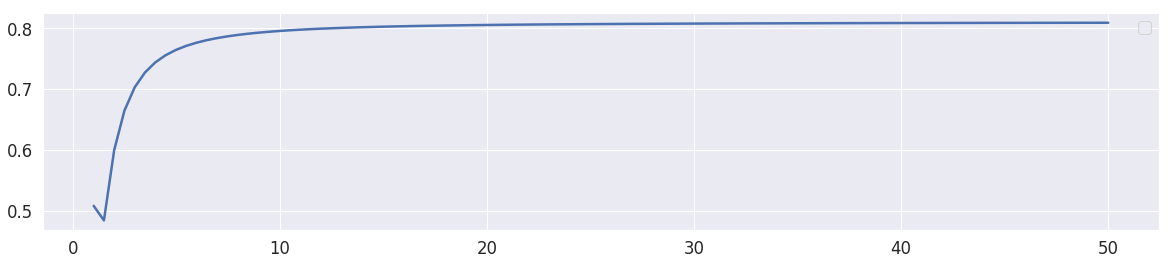

In [58]:
peaks=np.array(peaks)

plt.figure(figsize=(20,4))
plt.plot(d_series, peaks)
plt.legend()

0.7764840293856797
0.7764840293856797


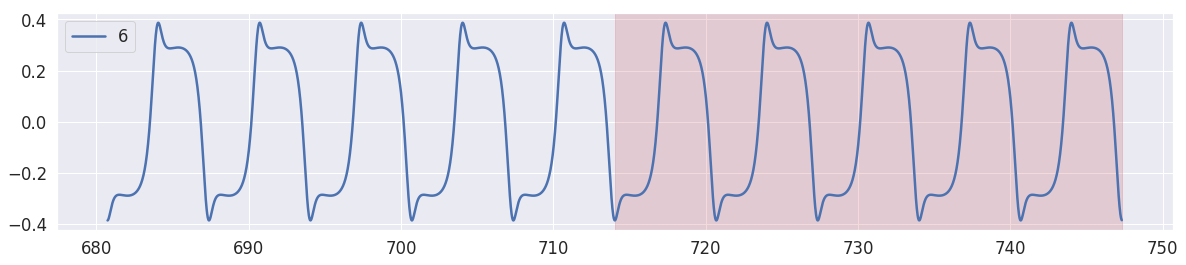

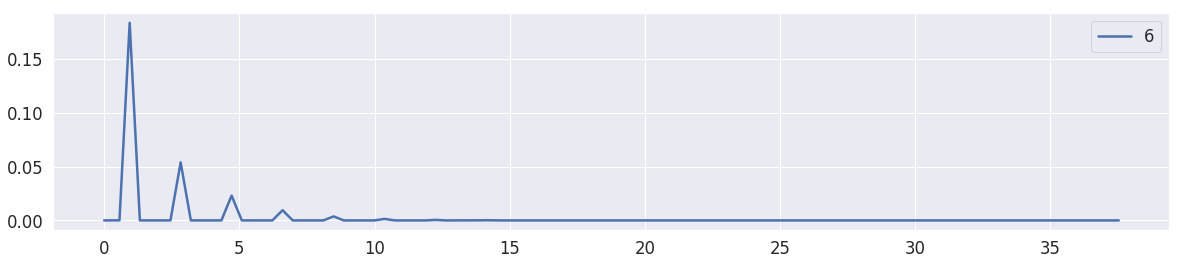

In [61]:
d=6
dw=0.2
beta=0
eps=0
dd=0
N_grid=int(max(d*800, 40000))
n=240

init=np.array([
        2*0.7*np.cos(np.pi/6),
        0.1*np.cos(np.pi/6)-0.7*np.sin(np.pi/6)*(-0.05+1),
        2*0.5*np.cos(np.pi/3),
        -0.05*np.cos(np.pi/3)-0.5*np.sin(np.pi/3)*(-0.1+1)
    ])

t, x, dx, y, dy, T, W, p=SystemSolve(d=d, dw=dw, beta=beta, eps=eps, dd=dd, N_grid=N_grid, n=n, init=init)

u=(x+y)/2
du=(dx+dy)/2
v=(x-y)/2
dv=(dx-dy)/2

rPart=-np.multiply(np.multiply(u, u), dv)-np.multiply(np.multiply(v, v), du)-2*np.multiply(np.multiply(v, u), du)+dw*u
target=np.min(rPart[-1000:])
eps=0.01
ind=argrelextrema(rPart, np.less)[0][np.abs(rPart[argrelextrema(rPart, np.less)]-target)<eps]

plt.figure(figsize=(20,4))
plt.plot(t[ind[-11]:ind[-1]], rPart[ind[-11]:ind[-1]], label=str(d))
argrelextrema(rPart, np.less)
plt.axvspan(xmin=t[ind[-6]], xmax=t[ind[-1]], color='r', alpha=0.2)
plt.legend()

p=int(N_grid/(n/2))

fig, ax=plt.subplots(figsize=(20,4))
#plt.magnitude_spectrum(rPart,Fs=2*np.pi/p)
res=ax.magnitude_spectrum(rPart[ind[-6]:ind[-1]], Fs=p)
mag=res[0]
freq=res[1] 
plt.close()

plt.figure(figsize=(20,4))
plt.plot(freq[:200], mag[:200], label=str(d))
plt.legend()
print(np.max(mag[1:])/np.sqrt(np.sum(np.multiply(mag[1:], mag[1:]))))
print(mag[argrelextrema(mag, np.greater)[0][0]]/np.sqrt(np.sum(np.multiply(mag[1:], mag[1:]))))

In [62]:
d_series=np.linspace(1, 10, 100)

peaks=[]
peaks2=[]

dw=0.2
beta=0
eps=0
dd=0
N_grid=int(max(d*400, 20000))
n=120

init=np.array([
        2*0.7*np.cos(np.pi/6),
        0.1*np.cos(np.pi/6)-0.7*np.sin(np.pi/6)*(-0.05+1),
        2*0.5*np.cos(np.pi/3),
        -0.05*np.cos(np.pi/3)-0.5*np.sin(np.pi/3)*(-0.1+1)
    ])


for d in d_series:


    t, x, dx, y, dy, T, W, p=SystemSolve(d=d, dw=dw, beta=beta, eps=eps, dd=dd, N_grid=N_grid, n=n, init=init)

    u=(x+y)/2
    du=(dx+dy)/2
    v=(x-y)/2
    dv=(dx-dy)/2

    rPart=-np.multiply(np.multiply(u, u), dv)-np.multiply(np.multiply(v, v), du)-2*np.multiply(np.multiply(v, u), du)+dw*u
    target=np.min(rPart[-1000:])
    eps=0.01
    ind=argrelextrema(rPart, np.less)[0][np.abs(rPart[argrelextrema(rPart, np.less)]-target)<eps]
    p=int(N_grid/(n/2))

    fig, ax=plt.subplots(figsize=(20,4))
    #plt.magnitude_spectrum(rPart,Fs=2*np.pi/p)
    res=ax.magnitude_spectrum(rPart[ind[-6]:ind[-1]], Fs=p)
    mag=res[0]
    freq=res[1] 
    plt.close()

    peaks.append(np.max(mag)/np.sqrt(np.sum(np.multiply(mag, mag))))
    peaks2.append(mag[argrelextrema(mag, np.greater)[0][0]]/np.sqrt(np.sum(np.multiply(mag[1:], mag[1:]))))
    print(d, end=' ')
 

1.0 1.0909090909090908 1.1818181818181819 1.2727272727272727 1.3636363636363638 1.4545454545454546 1.5454545454545454 1.6363636363636362 1.7272727272727273 1.8181818181818183 1.9090909090909092 2.0 2.090909090909091 2.1818181818181817 2.2727272727272725 2.3636363636363638 2.4545454545454546 2.5454545454545454 2.6363636363636367 2.7272727272727275 2.8181818181818183 2.909090909090909 3.0 3.090909090909091 3.1818181818181817 3.272727272727273 3.3636363636363638 3.4545454545454546 3.5454545454545454 3.6363636363636362 3.7272727272727275 3.8181818181818183 3.909090909090909 4.0 4.090909090909091 4.181818181818182 4.272727272727273 4.363636363636363 4.454545454545455 4.545454545454545 4.636363636363637 4.7272727272727275 4.818181818181818 4.909090909090909 5.0 5.090909090909091 5.181818181818182 5.2727272727272725 5.363636363636363 5.454545454545455 5.545454545454546 5.636363636363637 5.7272727272727275 5.818181818181818 5.909090909090909 6.0 6.090909090909091 6.181818181818182 6.2727272727

No handles with labels found to put in legend.


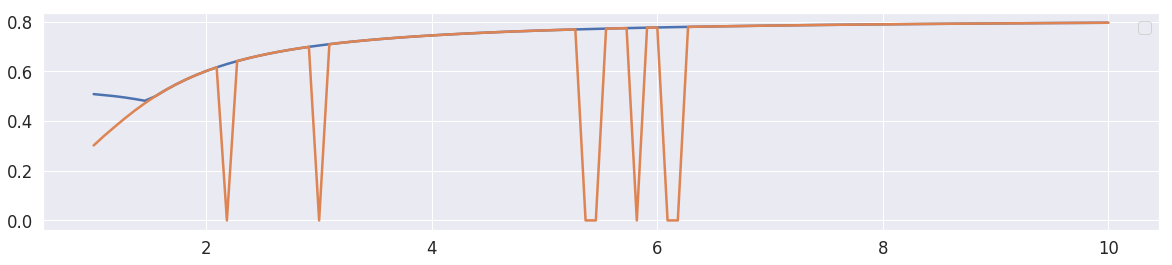

In [63]:
peaks=np.array(peaks)
peaks2=np.array(peaks2)


plt.figure(figsize=(20,4))
plt.plot(d_series, peaks)
plt.plot(d_series, peaks2)
plt.legend()

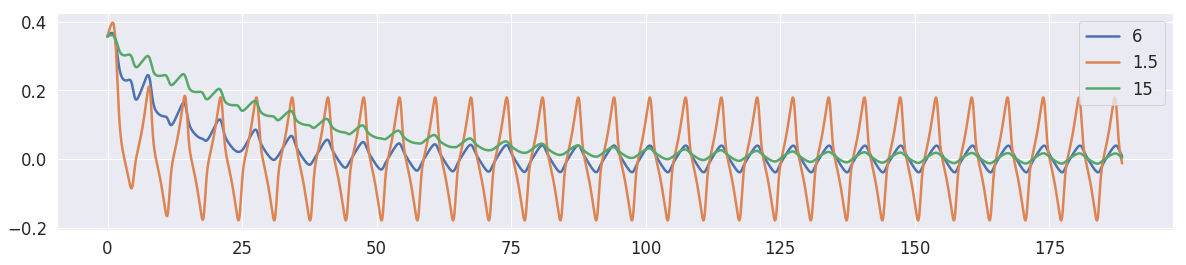

In [66]:
dw=0.2
beta=0
eps=0
dd=0
N_grid=int(max(d*200, 10000))
n=60

init=np.array([
        2*0.7*np.cos(np.pi/6),
        0.1*np.cos(np.pi/6)-0.7*np.sin(np.pi/6)*(-0.05+1),
        2*0.5*np.cos(np.pi/3),
        -0.05*np.cos(np.pi/3)-0.5*np.sin(np.pi/3)*(-0.1+1)
    ])



plt.figure(figsize=(20,4)) 

d=6
t, x, dx, y, dy, T, W, p=SystemSolve(d=d, dw=dw, beta=beta, eps=eps, dd=dd, N_grid=N_grid, n=n, init=init)
u=(x+y)/2
du=(dx+dy)/2
v=(x-y)/2
dv=(dx-dy)/2
plt.plot(t, v, label=str(d))

d=1.5
t, x, dx, y, dy, T, W, p=SystemSolve(d=d, dw=dw, beta=beta, eps=eps, dd=dd, N_grid=N_grid, n=n, init=init)
u=(x+y)/2
du=(dx+dy)/2
v=(x-y)/2
dv=(dx-dy)/2
plt.plot(t, v, label=str(d))

d=15
t, x, dx, y, dy, T, W, p=SystemSolve(d=d, dw=dw, beta=beta, eps=eps, dd=dd, N_grid=N_grid, n=n, init=init)
u=(x+y)/2
du=(dx+dy)/2
v=(x-y)/2
dv=(dx-dy)/2
plt.plot(t, v, label=str(d))

plt.legend()

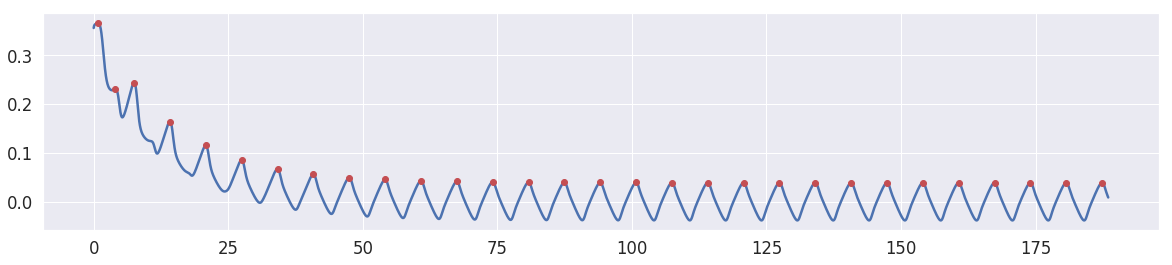

In [67]:
dw=0.2
beta=0
eps=0
dd=0
N_grid=int(max(d*200, 10000))
n=60

init=np.array([
        2*0.7*np.cos(np.pi/6),
        0.1*np.cos(np.pi/6)-0.7*np.sin(np.pi/6)*(-0.05+1),
        2*0.5*np.cos(np.pi/3),
        -0.05*np.cos(np.pi/3)-0.5*np.sin(np.pi/3)*(-0.1+1)
    ])



plt.figure(figsize=(20,4)) 

d=6
t, x, dx, y, dy, T, W, p=SystemSolve(d=d, dw=dw, beta=beta, eps=eps, dd=dd, N_grid=N_grid, n=n, init=init)
u=(x+y)/2
du=(dx+dy)/2
v=(x-y)/2
dv=(dx-dy)/2

plt.plot(t, v, label=str(d))


plt.plot(t[argrelextrema(v, np.greater)], v[argrelextrema(v, np.greater)], 'ro')

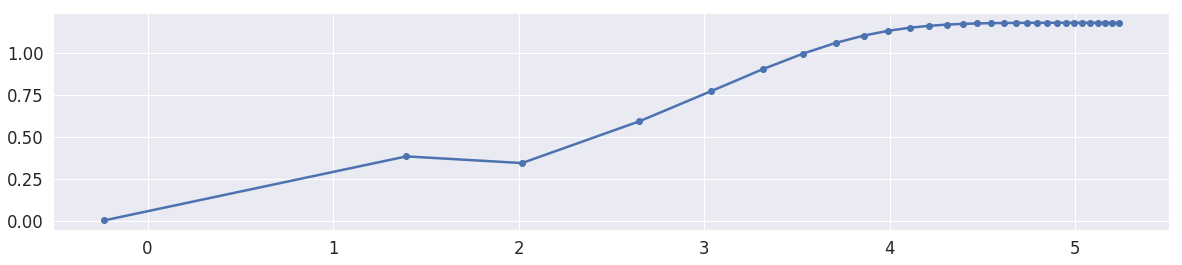

In [81]:
plt.figure(figsize=(20,4)) 
plt.plot(np.log(t[argrelextrema(v, np.greater)]), np.log(-np.log(v[argrelextrema(v, np.greater)])), 'o-')

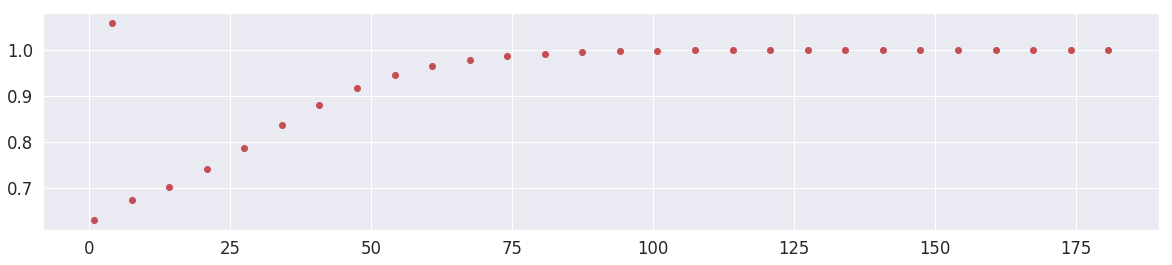

In [82]:
dat=v[argrelextrema(v, np.greater)]
rdat=np.array([
    dat[i+1]/dat[i] for i in range(dat.shape[0]-1)
])

plt.figure(figsize=(20,4)) 
plt.plot(t[argrelextrema(v, np.greater)][:-1], rdat, 'ro')